# Topic Modelling with MLlib

Author: Jesús Cid Sueiro

Date: 2016/04/10


In this notebook we will explore the utilitis for Topic Modelling available on MLlib.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pylab

# Required imports
from wikitools import wiki
from wikitools import category

# import nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from test_helper import Test

import collections

from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vectors

# import gensim
# import numpy as np
# import lda
# import lda.datasets

## 1. Corpus acquisition.

In this notebook we will explore some tools for text processing and analysis and two topic modeling algorithms available from Python toolboxes.

To do so, we will explore and analyze collections of Wikipedia articles from a given category, using `wikitools`, that makes easy the capture of content from wikimedia sites.

(*As a side note, there are many other available text collections to test topic modelling algorithm. In particular, the NLTK library has many examples, that can explore them using the `nltk.download()` tool*.

    import nltk
    nltk.download()

*for instance, you can take the gutemberg dataset*

    Mycorpus = nltk.corpus.gutenberg
    text_name = Mycorpus.fileids()[0]
    raw = Mycorpus.raw(text_name)
    Words = Mycorpus.words(text_name)

*Also, tools like Gensim or Sci-kit learn include text databases to work with*).

In order to use Wikipedia data, we will select a single category of articles:

In [2]:
site = wiki.Wiki("https://en.wikipedia.org/w/api.php")
# Select a category with a reasonable number of articles (>100)
cat = "Economics"
# cat = "Pseudoscience"
print cat

Economics


You can try with any other categories. Take into account that the behavior of topic modelling algorithms may depend on the amount of documents available for the analysis. Select a category with at least 100 articles. You can browse the wikipedia category tree here, https://en.wikipedia.org/wiki/Category:Contents, for instance.

We start downloading the text collection.

In [3]:
# Loading category data. This may take a while
print "Loading category data. This may take a while..."
cat_data = category.Category(site, cat)

corpus_titles = []
corpus_text = []

for n, page in enumerate(cat_data.getAllMembersGen()):
    print "\r Loading article {0}".format(n + 1),
    corpus_titles.append(page.title)
    corpus_text.append(page.getWikiText())

n_art = len(corpus_titles)
print "\nLoaded " + str(n_art) + " articles from category " + cat

Loading category data. This may take a while...
 Loading article 316 
Loaded 316 articles from category Economics


Now, we have stored the whole text collection in two lists:

* `corpus_titles`, which contains the titles of the selected articles
* `corpus_text`, with the text content of the selected wikipedia articles

You can browse the content of the wikipedia articles to get some intuition about the kind of documents that will be processed.

In [4]:
# n = 5
# print corpus_titles[n]
# print corpus_text[n]

Now, we will load the text collection into an RDD

In [5]:
corpusRDD = sc.parallelize(corpus_text, 4)
print "\nRDD created with {0} elements".format(corpusRDD.count())


RDD created with 316 elements


In [6]:
Test.assertTrue(corpusRDD.count() >= 100, 
                "Your corpus_tokens has less than 100 articles. Consider using a larger dataset")

1 test passed.


## 2. Corpus Processing

Topic modelling algorithms process vectorized data. In order to apply them, we need to transform the raw text input data into a vector representation. To do so, we will remove irrelevant information from the text data and preserve as much relevant information as possible to capture the semantic content in the document collection.

Thus, we will proceed with the following steps:

1. Tokenization
2. Homogeneization
3. Cleaning
4. Vectorization

The first three steps are independent for each document, so they can be parallelized.

### 2.1. Tokenization, Homogeneization and Cleaning.

For the first steps, we will use some of the powerfull methods available from the [Natural Language Toolkit](http://www.nltk.org). In order to use the `word_tokenize` method from nltk, you might need to get the appropriate libraries using `nltk.download()`. You must select option "d) Download", and identifier "punkt"

In [7]:
# You can comment this if the package is already available.
# Select option "d) Download", and identifier "punkt"
# nltk.download()

Also, we need to load a list of english stopwords. Select now identifier "stopwords"

In [8]:
# You can comment this if the package is already available.
# Select option "d) Download", and identifier "stopwords"
# nltk.download()

You can check the stopword list. This is a standard python list of strings. We could modify it by removing words or adding new ones if required.

In [9]:
stopwords_en = stopwords.words('english')

print "The stopword list contains {0} elements: ".format(len(stopwords_en))
print stopwords_en

The stopword list contains 153 elements: 
[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'

**Task**: Create a method `getTokenList` with two inputs: a document (string) and a stopword list, and completes the first three steps of the corpus processing, as follows:

1. Tokenization: convert string to `utf-8` and transform the string into a list of tokens, using `word_tokenize` from `nltk.tokenize`.
2. Homogeneization: transform capital letters to lowercase and remove non alphanumeric tokens.
3. Cleaning: remove stopwords

Return the result of cleaning (a list of tokens).

In [10]:
def getTokenList(doc, stopwords_en):
    
    # scode: tokens = <FILL IN>   # Tokenize docs
    tokens = word_tokenize(doc.decode('utf-8'))    

    # scode: tokens = <FILL IN>   # Remove non-alphanumeric tokens and normalize to lowercase
    tokens = [t.lower() for t in tokens if t.isalnum()]
    # scode: tokens = <FILL IN>   # Remove stopwords
    tokens = [t for t in tokens if t not in stopwords_en]

    return tokens

In [11]:
Test.assertEquals(getTokenList('The rain in spain stays mainly in the plane', stopwords_en), 
                  [u'rain', u'spain', u'stays', u'mainly', u'plane'],
                  'getTokenList does not return the expected results')

1 test passed.


**Task**: Apply `getTokenList` to all documents in the corpus and save the result in a `corpus_tokensRDD`

In [12]:
# scode: corpus_tokensRDD = <FILL IN>
corpus_tokensRDD = (corpusRDD
                   .map(lambda x: getTokenList(x, stopwords_en))
                   .cache())   

# print "\n Let's check tokens after cleaning:"
print corpus_tokensRDD.take(1)[0][0:30]

[u'social', u'disambiguation', u'theory', u'journal', u'economics', u'economics', u'sidebar', u'economics', u'social', u'science', u'describes', u'factors', u'determine', u'production', u'economics', u'distribution', u'economics', u'consumption', u'economics', u'goods', u'services', u'term', u'comes', u'ancient', u'greek', u'wikt', u'wikt', u'house', u'wikt', u'custom']


In [13]:
Test.assertEquals(corpus_tokensRDD.count(), n_art, 
                  "The number of documents in the original set does not correspond to the size of corpus_tokensRDD")
Test.assertTrue(all([c==c.lower() for c in corpus_tokensRDD.take(1)[0]]), 'Capital letters have not been removed')
Test.assertTrue(all([c.isalnum() for c in corpus_tokensRDD.take(1)[0]]), 
                'Non alphanumeric characters have not been removed')
Test.assertTrue(len([c for c in corpus_tokensRDD.take(1)[0] if c in stopwords_en])==0, 
                'Stopwords have not been removed')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


### 2.2. Stemming / Lemmatization

Now we will apply stemming and lemmatization to `corpus_tokensRDD`. We will test our topic models over the resulting RDDs, to test their differences.

**Task**: Apply stemming to all documents `corpus_tokensRDD` and save the result in a new RDD, `corpus_stemmedRDD`.

In [14]:
# Select stemmer.
stemmer = nltk.stem.SnowballStemmer('english')

# scode: corpus_stemRDD = <FILL IN>
corpus_stemRDD = corpus_tokensRDD.map(lambda x: [stemmer.stem(token) for token in x])

print "\nLet's check the first tokens from document 0 after stemming:"
print corpus_stemRDD.take(1)[0][0:30]


Let's check the first tokens from document 0 after stemming:
[u'social', u'disambigu', u'theori', u'journal', u'econom', u'econom', u'sidebar', u'econom', u'social', u'scienc', u'describ', u'factor', u'determin', u'product', u'econom', u'distribut', u'econom', u'consumpt', u'econom', u'good', u'servic', u'term', u'come', u'ancient', u'greek', u'wikt', u'wikt', u'hous', u'wikt', u'custom']


In [15]:
Test.assertTrue((len([c for c in corpus_stemRDD.take(1)[0] if c!=stemmer.stem(c)]) 
                 < 0.1*len(corpus_stemRDD.take(1)[0])), 
                'It seems that stemming has not been applied properly')

1 test passed.


Alternatively, we can apply lemmatization. For english texts, we can use the lemmatizer from NLTK, which is based on [WordNet](http://wordnet.princeton.edu). If you have not used wordnet before, you will likely need to download it from nltk

In [16]:
# You can comment this if the package is already available.
# Select option "d) Download", and identifier "wordnet"
# nltk.download()

**Task**: Lemmatize all documents `corpus_tokensRDD` using the .lemmatize() method, from the WordNetLemmatizer object created in the first line and save the result in a new RDD, `corpus_lemRDD`.

In [17]:
wnl = WordNetLemmatizer()

# scode: corpus_lemmatRDD = <FILL IN>
corpus_lemmatRDD = (corpus_tokensRDD
                    .map(lambda x: [wnl.lemmatize(token) for token in x]))

print "\nLet's check the first tokens from document 0 after stemming:"
print corpus_lemmatRDD.take(1)[0][0:30]


Let's check the first tokens from document 0 after stemming:
[u'social', u'disambiguation', u'theory', u'journal', u'economics', u'economics', u'sidebar', u'economics', u'social', u'science', u'describes', u'factor', u'determine', u'production', u'economics', u'distribution', u'economics', u'consumption', u'economics', u'good', u'service', u'term', u'come', u'ancient', u'greek', u'wikt', u'wikt', u'house', u'wikt', u'custom']


One of the advantages of the lemmatizer method is that the result of lemmatization is still a true word, which is more advisable for the presentation of text processing results and lemmatization.

However, without using contextual information, lemmatize() does not remove grammatical differences. This is the reason why "is" or "are" are preserved and not replaced by infinitive "be".

As an alternative, we can apply `.lemmatize(word, pos)`, where 'pos' is a string code specifying the part-of-speech (pos), i.e. the grammatical role of the words in its sentence. For instance, you can check the difference between `wnl.lemmatize('is')` and `wnl.lemmatize('is, pos='v')`.

### 2.4. Vectorization

Up to this point, we have transformed the raw text collection of articles in a list of articles, where each article is a collection of the word roots that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into a numerical representation (a list of vectors, or a matrix). 

#### 2.4.1. Word Count

As a first step, we compute the word count for every document in the corpus.

**Task**: Compute a new RDD from `corpus_stemRDD` where each element is a list of tuples related to a document. The key of each tuple is a token, and its value the number of occurrences of this token in the document. To do so, you can use method `Counter` from `collections`.

In [18]:
# corpus_wcRDD = <FILL IN>
corpus_wcRDD = (corpus_stemRDD
                .map(collections.Counter)
                .map(lambda x: [(t, x[t]) for t in x]))

print corpus_wcRDD.take(1)[0][0:30]

[(u'entropi', 1), (u'four', 1), (u'protest', 1), (u'asian', 1), (u'freshwat', 1), (u'payoff', 1), (u'whose', 1), (u'accus', 2), (u'voter', 1), (u'swan', 1), (u'346', 1), (u'edward', 6), (u'343', 1), (u'worth', 1), (u'merchant', 3), (u'everi', 4), (u'risk', 8), (u'rise', 4), (u'voic', 1), (u'distort', 2), (u'govern', 31), (u'jacob', 2), (u'affect', 8), (u'viewabl', 1), (u'chapel', 1), (u'disturb', 1), (u'prize', 6), (u'correct', 3), (u'enquir', 1), (u'elgar', 3)]


In [19]:
Test.assertTrue(corpus_wcRDD.count() == n_art, 'List corpus_clean does not contain the expected number of articles')
Test.assertTrue(corpus_wcRDD.flatMap(lambda x: x).map(lambda x: x[1]).sum()== corpus_stemRDD.map(len).sum(), 
                'The total token count in the output RDD is not consistent with the total number of input tokens')

1 test passed.
1 test passed.


At this point, we have got a representation of documents as list of tuples `(token, word_count)` in `corpus_wcRDD`. From this RDD, we can compute a dictionary containing all tokens in the corpus as keys, and their respective number of occurrences as values.

**Task**: Using `corpus_wcRDD` compute a new RDD of `(key, value)` pairs, where keys are the tokens in the whole corpus and their respective values are the total number of occurences in the corpus.

In [20]:
# scode: wcRDD = < FILL IN >
wcRDD = (corpus_wcRDD
         .flatMap(lambda x: x)
         .reduceByKey(lambda x, y: x + y))

print wcRDD.take(30)

[(u'entropi', 1), (u'four', 57), (u'catch', 2), (u'roadblock', 1), (u'fredric', 1), (u'theodor', 5), (u'kerala', 4), (u'crete', 1), (u'freshwat', 1), (u'cyprus', 1), (u'fudg', 1), (u'introd', 2), (u'categori', 1136), (u'stationeri', 1), (u'160', 4), (u'tobia', 1), (u'charnley', 1), (u'groundwork', 2), (u'340', 1), (u'rickman', 1), (u'pamela', 1), (u'lautenbachsch', 1), (u'lora', 1), (u'merchant', 34), (u'20antiqu', 1), (u'everi', 83), (u'scientia', 1), (u'hough', 1), (u'distortionari', 1), (u'escudero', 3)]


**Task**: Take all tuples in `wcRDD` in decreasing order of the number of token counts in variable `TD` and compute two lists: 

1. `token_count`: a list of token counts, in decreasing order.
2. `D`: A list of tokens, in the same order.

In [2]:
# Token Dictionary:
n_tokens = wcRDD.count()
# scode: TD = wcRDD.<FILL IN>
TD = wcRDD.takeOrdered(n_tokens, lambda x: -x[1])

# scode: D = <FIll IN>    # Extract tokens from TD
D = map(lambda x: x[0], TD)
# scode: token_count = <FILL IN>   # Extract token counts from TD
token_count = map(lambda x: x[1], TD)   

# ALTERNATIVELY:
TD_RDD = wcRDD.sortBy(lambda x: -x[1])
D_RDD = TD_RDD.map(lambda x: x[0])
token_countRDD = TD_RDD.map(lambda x: x[1])

print TD

NameError: name 'wcRDD' is not defined

We can visualize the token distribution using `D` and `token_count`, for the most frequent terms

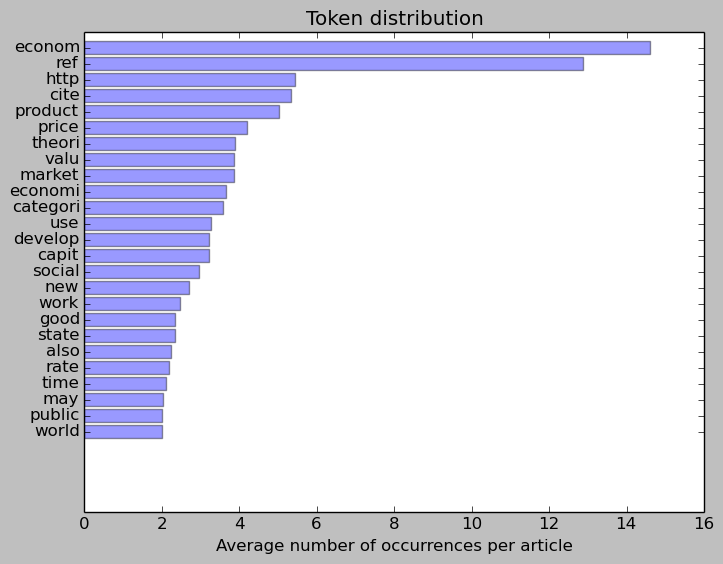

In [22]:
# SORTED TOKEN FREQUENCIES (II):
# plt.rcdefaults()

# Example data
n_bins = 25
y_pos = range(n_bins-1, -1, -1)
hot_tokens = D[0:n_bins]
z = [float(t)/n_art for t in token_count[0:n_bins]]

plt.barh(y_pos, z, align='center', alpha=0.4)
plt.yticks(y_pos, hot_tokens)
plt.xlabel('Average number of occurrences per article')
plt.title('Token distribution')
plt.show()

## 3. Latent Dirichlet Allocation

In order to apply the LDA algorithm, we need to represent the input documents in the format required by MLlib. More specifically. The input data should be an RDD where each element is a tuple

    (doc_id, vector)

where `doc_id` is an integer document identifier, and `vector` can be a sparse or dense vector from class `Vectors`. We will use sparse vectors, which are more adequate for large vocabularies. 

To compute the sparse vectors, we must first transform the lists of tuples `(token, value)` in `wcRDD` into a lists of `(token_id, value)`, pairs, thus replacing each token by a numerical identifier.

We will proceed in two steps:

1. Compute an inverse dictionary, `invD`, transforming tokens into numbers.
2. Apply the inverse dictionary to compute a new RDD from `wcRDD` replacing each token by its `token_id`.

[** Task**: complete the two steps outlined above.

In [23]:
# INDICE INVERTIDO: EJEMPLO:
# D = ['token1', 'token2', 'token3', 'token4']
# D[1] = 'token2'
# invD = {'token1': 0, 'token2': 1, 'token3': 2, 'token4': 3}
# invD['token2'] = 1






# Compute inverse dictionary
# scode: invD = <FILL IN>
invD = dict(zip(D, xrange(n_tokens)))

### ALTERNATIVELY:
# invD_RDD = D_RDD.zipWithIndex()      ### Tuples (token, index)

# Compute RDD replacing tokens by token_ids
# scode: corpus_sparseRDD = <FILL IN>
corpus_sparseRDD = corpus_wcRDD.map(lambda x: [(invD[t[0]], t[1]) for t in x])

# Convert list of tuplas into Vectors.sparse object.
corpus_sparseRDD = corpus_sparseRDD.map(lambda x: Vectors.sparse(n_tokens, x))

The only remaining step consists on adding an identifier to each document of the corpus.

**Task**: Apply method `zipWithIndex` to `corpus_sparseRDD` in order to add consecutive integer identifiers to all documents in the corpus.

In [24]:
corpus4lda = corpus_sparseRDD.zipWithIndex().map(lambda x: [x[1], x[0]]).cache()

That's all. We can already call to the lda algorithm.'

**Task**: Train an LDA model with 3 topics and the corpus obtained in `corpus4lda`. Check the [LDA documentation](http://spark.apache.org/docs/latest/mllib-clustering.html#latent-dirichlet-allocation-lda) to find the appropriate command.

In [25]:
print "Training LDA: this might take a while..."
# scode: ldaModel = LDA.<FILL IN>
ldaModel = LDA.train(corpus4lda, k=3)

Training LDA: this might take a while...


The whole topics matrix can be computed using the `.topicsMatrix()` method.

In [26]:
# Output topics. Each is a distribution over words (matching word count vectors)
print("Learned topics (as distributions over vocab of " + str(ldaModel.vocabSize()) + " words):")
topics = ldaModel.topicsMatrix()

Learned topics (as distributions over vocab of 14905 words):


Alternatively, we can use the `.describeTopics` method that returns the most relevan terms for each topic, and it is more useful for a graphical plot.

**Task**: Represent the 25 most relevant terms for each topic using bar plots.

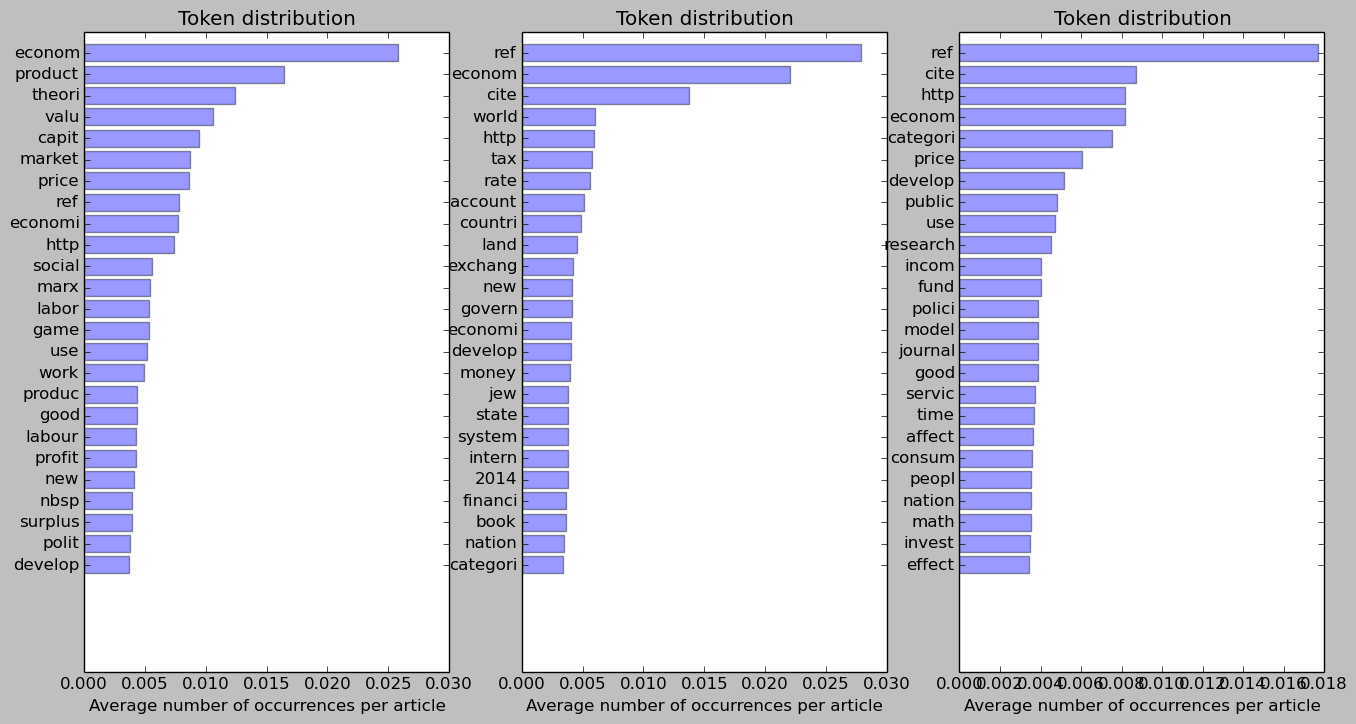

In [27]:
n_bins = 25
    
# Example data
y_pos = range(n_bins-1, -1, -1)

pylab.rcParams['figure.figsize'] = 16, 8  # Set figure size
for i in range(3):
    
    topic = ldaModel.describeTopics(maxTermsPerTopic=n_bins)[i]
    tokens = [D[n] for n in topic[0]]
    weights = topic[1]

    plt.subplot(1, 3, i+1)
    plt.barh(y_pos, weights, align='center', alpha=0.4)
    plt.yticks(y_pos, tokens)
    plt.xlabel('Average number of occurrences per article')
    plt.title('Token distribution')

**Exercise**: Explore the influence of the `topicConcentration` parameter. Show in barplots the most relevant tokens for each topic for large values of this parameter.

Unfortunately, we cannot capture the document distributions over topics, in the current version of pySpark mllib (1.6).

## 4. Latent Semantic Indexing

LSI is not specifically available in MLlib, There are methods to compute the SVD decomposition of a matrix, which is the core transformation for LSI, but, unfortunately, SVD decomposition is available in Java and Scala, but not in python. 

The following code, taken from Stackoverflow, can be used to compute the SVD.

In [28]:
from pyspark.mllib.common import callMLlibFunc, JavaModelWrapper
from pyspark.mllib.linalg.distributed import RowMatrix

class SVD(JavaModelWrapper):
    """Wrapper around the SVD scala case class"""
    @property
    def U(self):
        """ Returns a RowMatrix whose columns are the left singular vectors of the SVD if computeU was set to be True."""
        u = self.call("U")
        if u is not None:
            return RowMatrix(u)

    @property
    def s(self):
        """Returns a DenseVector with singular values in descending order."""
        return self.call("s")

    @property
    def V(self):
        """ Returns a DenseMatrix whose columns are the right singular vectors of the SVD."""
        return self.call("V")


In [29]:
def computeSVD(row_matrix, k, computeU=False, rCond=1e-9):
    """
    Computes the singular value decomposition of the RowMatrix.
    The given row matrix A of dimension (m X n) is decomposed into U * s * V'T where
    * s: DenseVector consisting of square root of the eigenvalues (singular values) in descending order.
    * U: (m X k) (left singular vectors) is a RowMatrix whose columns are the eigenvectors of (A X A')
    * v: (n X k) (right singular vectors) is a Matrix whose columns are the eigenvectors of (A' X A)
    :param k: number of singular values to keep. We might return less than k if there are numerically zero singular values.
    :param computeU: Whether of not to compute U. If set to be True, then U is computed by A * V * sigma^-1
    :param rCond: the reciprocal condition number. All singular values smaller than rCond * sigma(0) are treated as zero, where sigma(0) is the largest singular value.
    :returns: SVD object
    """
    java_model = row_matrix._java_matrix_wrapper.call("computeSVD", int(k), computeU, float(rCond))
    return SVD(java_model)

In [30]:
from pyspark.ml.feature import *
from pyspark.mllib.linalg import Vectors

data = [(Vectors.dense([0.0, 1.0, 0.0, 7.0, 0.0]),), (Vectors.dense([2.0, 0.0, 3.0, 4.0, 5.0]),), (Vectors.dense([4.0, 0.0, 0.0, 6.0, 7.0]),)]
df = sqlContext.createDataFrame(data,["features"])

pca_extracted = PCA(k=2, inputCol="features", outputCol="pca_features")

model = pca_extracted.fit(df)
features = model.transform(df) # this create a DataFrame with the regular features and pca_features

# We can now extract the pca_features to prepare our RowMatrix.
pca_features = features.select("pca_features").rdd.map(lambda row : row[0])
mat = RowMatrix(pca_features)

# Once the RowMatrix is ready we can compute our Singular Value Decomposition
svd = computeSVD(mat,2,True)

print svd.s
# DenseVector([9.491, 4.6253])
print svd.U.rows.collect()
# [DenseVector([0.1129, -0.909]), DenseVector([0.463, 0.4055]), DenseVector([0.8792, -0.0968])]
print svd.V
# DenseMatrix(2, 2, [-0.8025, -0.5967, -0.5967, 0.8025], 0)


[9.49101642128,4.62528901289]
[DenseVector([0.1129, -0.909]), DenseVector([0.463, 0.4055]), DenseVector([0.8792, -0.0968])]
DenseMatrix([[-0.80247931, -0.59667995],
             [-0.59667995,  0.80247931]])


**Task**: Adapt the code above to compute the LSI topic model of `corpus4lda`.